# 4. 이미지 어디까지 우려볼까?

## 이번 노드는 제한된 데이터셋을 사골이 되도록  우리고 우려서 많은 데이터셋으로 불리기 위한 노드입니다.

## 학습을 시키기에 데이터셋과 돈이 없는 우리에겐 시간을 써서 데이터와 맞바꾸는 작업이 필요하죠.

## 이 장의 어그멘테이션이 거기에 딱 맞는 해답입니다.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print('=3')

=3


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. 데이터 불러오기
그리고 사용할 데이터셋을 불러옵니다. 이번 시간에는 stanford_dogs 데이터셋을 사용해보도록 합시다. stanford_dogs 데이터셋에는 120개 견종의 이미지가 포함되어 있습니다. 총 20,580장의 이미지에서 12,000장은 학습셋, 나머지 8,580장은 평가용 데이터셋입니다.

데이터를 처음 사용한다면 다운로드해야 하기 때문에 시간이 오래(10분 이상) 걸릴 수 있습니다. 당황하지 마시고 잠시 휴식 시간을 가져 보세요. 데이터셋은 다른 프로젝트에서도 사용할 수 있으니 프로젝트 디렉토리가 아닌 TensorFlow Datasets 기본 디렉토리에 저장합시다.

In [3]:

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
=3


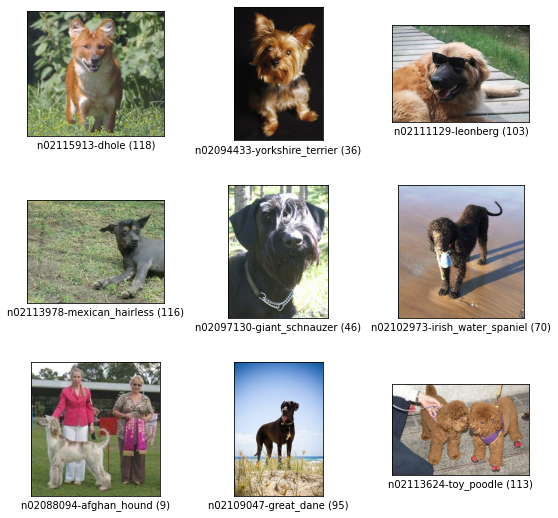

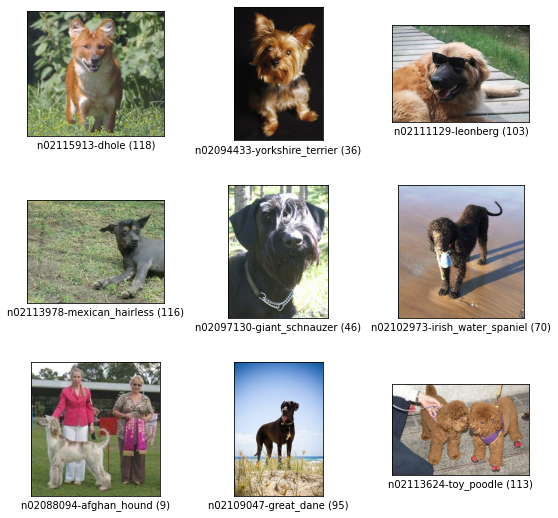

In [4]:
tfds.show_examples(ds_train, ds_info)

## 텐서플로우 Random Augmentation API 사용하기


그럼 Augmentation을 적용하기에 앞서 기본적인 전처리 함수를 만들어 줍시다.

In [5]:
#이미지를 변환하는 전처리 함수는 대략 다음과 같은 형태를 가지게 됩니다.


def 전처리_함수(image, label):   # 변환할 이미지와 라벨
     # 이미지 변환 로직 적용
    new_image = 이미지_변환(image)
    return new_image, label
#========================================================

def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

print('=3')

=3


In [6]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')



=3


## Random Augmentation 직접 구현하기
위에서는 미리 구현된 random augmentation을 적용하도록 augment() 함수를 작성했습니다. 
이번에는 tf.image의 다양한 함수들을 이용해서 직접 다양한 augmentation 기법을 랜덤하게 적용하는 augment2() 함수를 작성해보세요. 

In [7]:
def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    image = tf.image.resize(image, [224, 224])
    return image, label

## 비교실험 하기

In [8]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

94773248/94765736 [==============================] - 1s 0us/step
=3


In [9]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [36]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
print('=3')

=3


In [13]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 1

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

750/750 [==============================] - 332s 432ms/step - loss: 3.2076 - accuracy: 0.2758 - val_loss: 3.5538 - val_accuracy: 0.1923


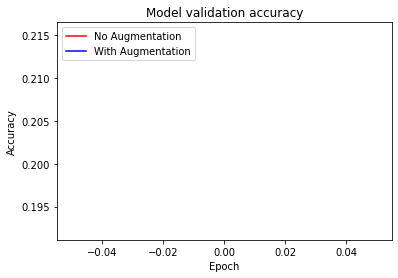

In [14]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

## 심화 기법 (1) Cutmix Augmentation

### 1) 이미지 섞기

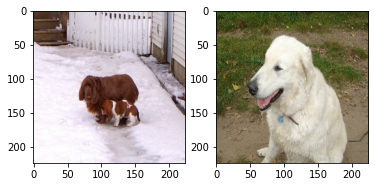

In [16]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

두 개의 이미지를 얻었습니다.

이 중 첫 번째 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두 번째 이미지 b가 있을 때, a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수를 먼저 구현해 봅시다.

이번 노드에서는 이미지 a, b가 모두 (224, 224)로 resize되어 두 이미지의 width, height가 같은 경우로 가정할 수 있지만, CutMix 공식 repo 에서는 width, height가 다르더라도 가변적으로 적용할 수 있도록 구현되어 있기 때문에, 임의의 이미지 사이즈에 대해서도 유연하게 대응 가능하도록 구현해 보겠습니다.

In [17]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(176, shape=(), dtype=int32)
y :  tf.Tensor(24, shape=(), dtype=int32) tf.Tensor(169, shape=(), dtype=int32)


바탕이미지 image_a에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 image_b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수를 구현해 봅시다.

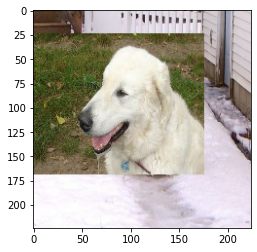

In [18]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

### 2) 라벨 섞기


In [19]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.4913903, 0.       , 0.5086097,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
   

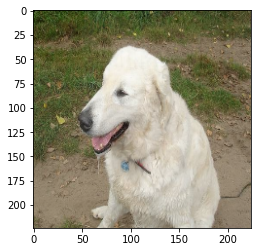

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.08799589 0.         0.9120041
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.  

In [20]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [21]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


In [22]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

# 프로젝트: CutMix 또는 Mixup 비교실험 하기

## 1. Augmentation을 적용한 데이터셋 만들기

OneHot 함수 생성 : 상민님 코드
https://www.notion.so/modulabs/cf6c5f738dfc492997e730553e653229

- 원-핫 인코딩은 단어 집합의 크기를 벡터의 차원으로 하고, 표현하고 싶은 단어의 인덱스에 1의 값을 부여하고, 다른 인덱스에는 0을 부여하는 단어의 벡터 표현 방식입니다.

- 이렇게 표현된 벡터를 원-핫 벡터(One-Hot vector)라고 합니다.

- 원 핫 인코딩을 쓰는 이유 : 
    - 우리는 이미지 2장을 합성하기 때문에 1번 사진 50%, 2번 사진 50%를 섞어서 새로운 공간에 넣어야 합니다.
    - 기존의 라벨링 공간이 1~100까지 있다고 하면 1번과 2번 사진을 섞은 새로운 사진을 어디에 저장해야 할 까요?
    - 이럴 때 원 핫 인코딩을 함수를 사용하여 컴퓨터 입장에서 가장 빠른 결과를 낼 수 있게 끔 합니다.
- 원 핫 인코딩은 NLP에서 사용하는 개념이지만,  CV와 NLP의 구분이 필요가 없습니다!
- 각자가 필요한 개념을 적절히 섞어서 사용하면 이번 노드처럼 새로운 결과물이 생기기 때문이죠!

### 사람들 가장 멘탈 많이 터졌던 부분. 옛날 코드 -> 교체

#### 사진 자연스럽게 섞기

In [23]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label


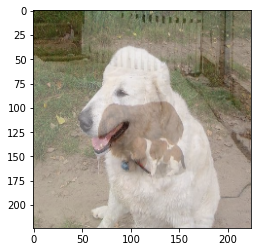

In [24]:
mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()

In [25]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

# def augment(image,label):
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_brightness(image, max_delta=0.2)
#     image = tf.clip_by_value(image, 0, 1)
#     return image, label

print('=3')

AUTO = tf.data.experimental.AUTOTUNE

def onehot(image,label):
    CLASSES = 120
    return image,tf.one_hot(label,CLASSES)


# =======
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds
#=======
def apply_normalize_on_dataset_cutmix(ds, is_test=False, batch_size=16, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )

    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


def apply_normalize_on_dataset_mixup(ds, is_test=False, batch_size=16, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    
    ds = ds.batch(batch_size)
    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

=3


In [26]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [27]:
ds_train_cutmix = apply_normalize_on_dataset_cutmix(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset_mixup(ds_train, with_mixup=True)

In [28]:
ds_test_cutmix = apply_normalize_on_dataset_cutmix(ds_test, is_test=True)
ds_test_mixup = apply_normalize_on_dataset_mixup(ds_test, is_test=True)

## 2. 모델 만들기
앞서 만들었던 것처럼 비교 실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.

### no_augmentation_resnet50

In [29]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

### augmentation_resnet50

In [30]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

### cutmix_resnet50

In [31]:
cutmix_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

### mixup_resnet50

In [32]:
mixup_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

resnet50 - no augmentation

## 3. 모델 훈련하기
주의!! 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 **sparse_categorical_crossentropy()** 대신 **categorical_crossentropy()** 를 사용해 주세요!


In [33]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')])

## resnet50_no_augmentation

In [34]:
EPOCH = 20

In [37]:
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 332s 432ms/step - loss: 0.7066 - accuracy: 0.8151 - val_loss: 1.3687 - val_accuracy: 0.6209
Epoch 2/20
750/750 [==============================] - 323s 431ms/step - loss: 0.3269 - accuracy: 0.9231 - val_loss: 0.9522 - val_accuracy: 0.7259
Epoch 3/20
750/750 [==============================] - 323s 431ms/step - loss: 0.0877 - accuracy: 0.9899 - val_loss: 0.9168 - val_accuracy: 0.7410
Epoch 4/20
750/750 [==============================] - 323s 431ms/step - loss: 0.0499 - accuracy: 0.9948 - val_loss: 0.9224 - val_accuracy: 0.7417
Epoch 5/20
750/750 [==============================] - 323s 431ms/step - loss: 0.0237 - accuracy: 0.9993 - val_loss: 0.9276 - val_accuracy: 0.7422
Epoch 6/20
750/750 [==============================] - 323s 431ms/step - loss: 0.0126 - accuracy: 0.9997 - val_loss: 0.9243 - val_accuracy: 0.7462
Epoch 7/20
750/750 [==============================] - 323s 431ms/step - loss: 0.0106 - accuracy: 0.9997 - val_loss: 0.9380 -

## resnet50_augmentation

In [38]:
aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)


history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 332s 432ms/step - loss: 3.2111 - accuracy: 0.2748 - val_loss: 3.3981 - val_accuracy: 0.2073
Epoch 2/20
750/750 [==============================] - 327s 436ms/step - loss: 1.0556 - accuracy: 0.6992 - val_loss: 1.1917 - val_accuracy: 0.6525
Epoch 3/20
750/750 [==============================] - 323s 431ms/step - loss: 0.5506 - accuracy: 0.8470 - val_loss: 1.0159 - val_accuracy: 0.6969
Epoch 4/20
750/750 [==============================] - 323s 431ms/step - loss: 0.2773 - accuracy: 0.9314 - val_loss: 1.0283 - val_accuracy: 0.7029
Epoch 5/20
750/750 [==============================] - 323s 431ms/step - loss: 0.1380 - accuracy: 0.9721 - val_loss: 0.9628 - val_accuracy: 0.7304
Epoch 6/20
750/750 [==============================] - 323s 431ms/step - loss: 0.0797 - accuracy: 0.9892 - val_loss: 1.0040 - val_accuracy: 0.7232
Epoch 7/20
750/750 [==============================] - 323s 431ms/step - loss: 0.0447 - accuracy: 0.9954 - val_loss: 0.9706 -

## resnet50_cutmix_augmentation

In [39]:
cutmix_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_aug_resnet50.fit(
    ds_train_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_cutmix,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 335s 435ms/step - loss: 4.3770 - accuracy: 0.1063 - val_loss: 3.1072 - val_accuracy: 0.2350
Epoch 2/20
750/750 [==============================] - 324s 432ms/step - loss: 3.0619 - accuracy: 0.3952 - val_loss: 1.3134 - val_accuracy: 0.6374
Epoch 3/20
750/750 [==============================] - 325s 433ms/step - loss: 2.6835 - accuracy: 0.5163 - val_loss: 1.2886 - val_accuracy: 0.6421
Epoch 4/20
750/750 [==============================] - 325s 433ms/step - loss: 2.4634 - accuracy: 0.5826 - val_loss: 1.3406 - val_accuracy: 0.6350
Epoch 5/20
750/750 [==============================] - 324s 432ms/step - loss: 2.3271 - accuracy: 0.6345 - val_loss: 1.2265 - val_accuracy: 0.6709
Epoch 6/20
750/750 [==============================] - 325s 433ms/step - loss: 2.1812 - accuracy: 0.6715 - val_loss: 1.3011 - val_accuracy: 0.6522
Epoch 7/20
750/750 [==============================] - 325s 433ms/step - loss: 2.1021 - accuracy: 0.7037 - val_loss: 1.1775 -

## resnet50_mixup_augmentation

In [40]:
mixup_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_aug_resnet50.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_mixup,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 336s 436ms/step - loss: 4.2695 - accuracy: 0.1305 - val_loss: 4.0660 - val_accuracy: 0.1189
Epoch 2/20
750/750 [==============================] - 325s 433ms/step - loss: 2.9582 - accuracy: 0.4426 - val_loss: 1.3794 - val_accuracy: 0.6052
Epoch 3/20
750/750 [==============================] - 324s 432ms/step - loss: 2.6516 - accuracy: 0.5455 - val_loss: 1.6258 - val_accuracy: 0.5633
Epoch 4/20
750/750 [==============================] - 325s 433ms/step - loss: 2.4372 - accuracy: 0.6360 - val_loss: 1.2473 - val_accuracy: 0.6564
Epoch 5/20
750/750 [==============================] - 325s 433ms/step - loss: 2.3093 - accuracy: 0.6873 - val_loss: 1.2392 - val_accuracy: 0.6581
Epoch 6/20
750/750 [==============================] - 325s 433ms/step - loss: 2.1506 - accuracy: 0.7467 - val_loss: 1.2672 - val_accuracy: 0.6537
Epoch 7/20
750/750 [==============================] - 326s 435ms/step - loss: 2.1104 - accuracy: 0.7521 - val_loss: 1.3368 -

## 4. 훈련 과정 시각화하기

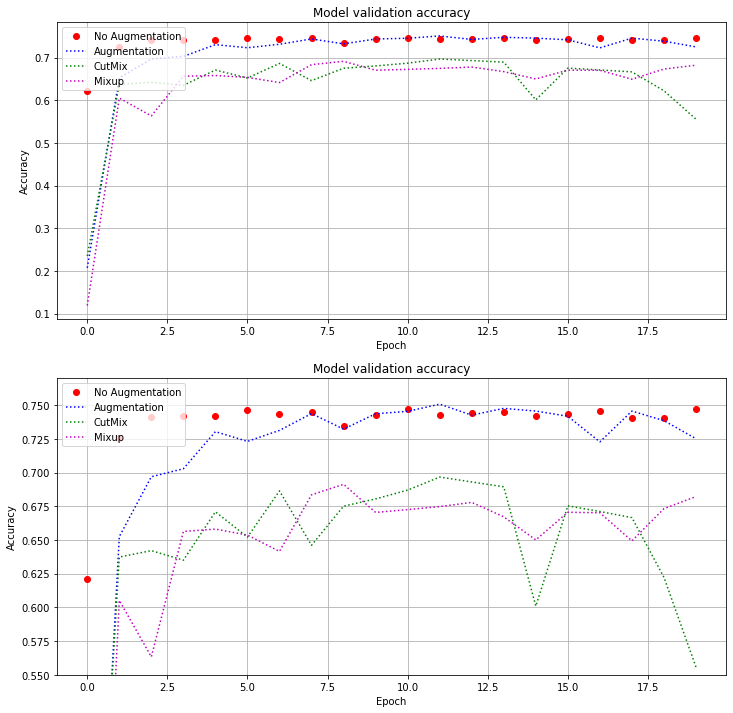

In [48]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'ro')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b:')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g:')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'm:')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'CutMix', 'Mixup'], loc='upper left')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'ro')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b:')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g:')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'm:')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'CutMix', 'Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.55, 0.770)   

plt.show()

# Loss 

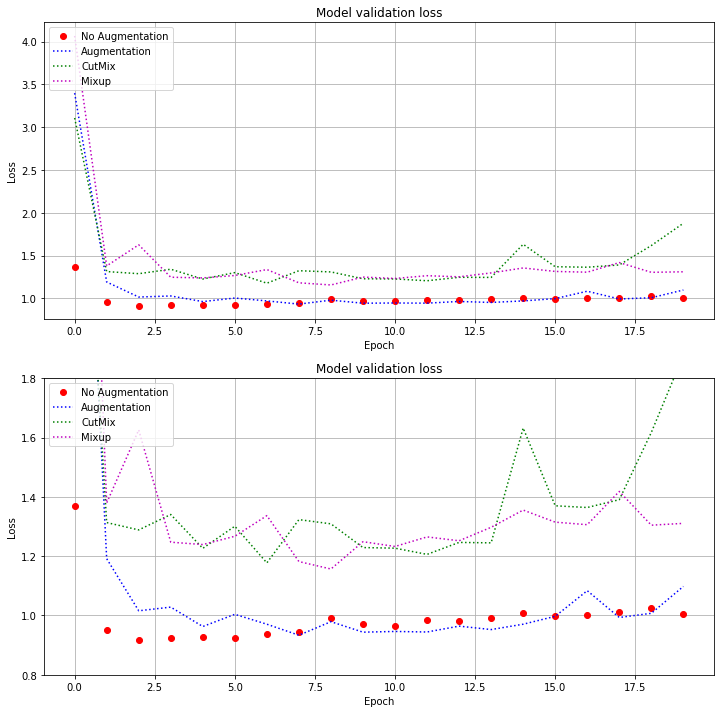

In [49]:
# 훈련 과정 시각화
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'ro')
plt.plot(history_resnet50_aug.history['val_loss'], 'b:')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g:')
plt.plot(history_resnet50_mixup.history['val_loss'], 'm:')

plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'CutMix', 'Mixup'], loc='upper left')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'ro')
plt.plot(history_resnet50_aug.history['val_loss'], 'b:')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g:')
plt.plot(history_resnet50_mixup.history['val_loss'], 'm:')

plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'CutMix', 'Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.80, 1.80)  
plt.show()

plt.show()

## 5. Augmentation에 의한 모델 성능 비교
No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.

In [50]:
import pandas as pd

In [51]:
val_acc_dict = {'No Augmentation': history_resnet50_no_aug.history['val_accuracy'], 
            'Augmentation': history_resnet50_aug.history['val_accuracy'], 
            'CutMix': history_resnet50_cutmix.history['val_accuracy'], 
            'Mixup': history_resnet50_mixup.history['val_accuracy']}
df1 = pd.DataFrame(val_acc_dict)
df1

,No Augmentation,Augmentation,CutMix,Mixup
0,0.620919,0.207323,0.234958,0.118937
1,0.725863,0.652519,0.637360,0.605177
2,0.741021,0.696945,0.642141,0.563316
3,0.741721,0.702892,0.635028,0.656367
4,0.742188,0.730410,0.670942,0.658116
5,0.746152,0.723181,0.652169,0.653685
6,0.743820,0.731343,0.686451,0.641558
7,0.744986,0.743820,0.646105,0.683535
8,0.734492,0.732276,0.675140,0.691348
9,0.743004,0.743703,0.680504,0.670476


In [52]:
df1.mean()

No Augmentation    0.736165
Augmentation       0.703539
CutMix             0.635967
Mixup              0.631542
dtype: float64

# LOSS

In [53]:
val_loss_dict = {'No Augmentation': history_resnet50_no_aug.history['val_loss'], 
            'Augmentation': history_resnet50_aug.history['val_loss'], 
            'CutMix': history_resnet50_cutmix.history['val_loss'], 
            'Mixup': history_resnet50_mixup.history['val_loss']}
df2 = pd.DataFrame(val_loss_dict)
df2

,No Augmentation,Augmentation,CutMix,Mixup
0,1.368730,3.398064,3.107217,4.065964
1,0.952153,1.191653,1.313415,1.379416
2,0.916816,1.015878,1.288631,1.625835
3,0.922427,1.028291,1.340592,1.247285
4,0.927612,0.962824,1.226472,1.239239
5,0.924269,1.004007,1.301054,1.267185
6,0.938033,0.970630,1.177465,1.336794
7,0.944949,0.933433,1.323358,1.181902
8,0.992828,0.979196,1.309127,1.156786
9,0.971723,0.943762,1.229129,1.248880


In [54]:
df2.mean

<bound method NDFrame._add_numeric_operations.<locals>.mean of     No Augmentation  Augmentation    CutMix     Mixup
0          1.368730      3.398064  3.107217  4.065964
1          0.952153      1.191653  1.313415  1.379416
2          0.916816      1.015878  1.288631  1.625835
3          0.922427      1.028291  1.340592  1.247285
4          0.927612      0.962824  1.226472  1.239239
5          0.924269      1.004007  1.301054  1.267185
6          0.938033      0.970630  1.177465  1.336794
7          0.944949      0.933433  1.323358  1.181902
8          0.992828      0.979196  1.309127  1.156786
9          0.971723      0.943762  1.229129  1.248880
10         0.964136      0.946205  1.227062  1.232812
11         0.983188      0.944347  1.206129  1.265051
12         0.980646      0.964120  1.246476  1.251998
13         0.991807      0.952578  1.244969  1.297526
14         1.008372      0.970602  1.632213  1.355561
15         0.997555      0.997254  1.370003  1.314829
16         1.002994

# 회고

- 누군가의 에러(라고 쓰고 삽질이라고 읽는다) 소식을 듣고 걱정했지만 상민님의 발빠른 대처에 나는 아무런 피해없이 노드 진행이 가능했다.
    - 역시 천천히 풀면 앞서 나가던 사람들이 함정위치를 알려줘서 뭔가 편한거 같다.
    - 나중엔 내가 함정에 빠지고 뒷사람들한테 위치 표시해주겠지
- 3번의 어그멘테이션 노드의 개념은 이해한 것 같은데, 막상 사용하려니 막막해서 누군가의 도움을 많이 받았다.
    
- 노드 풀로 돌리는데 8시간이 걸린다고 해서 겁이 났는데, 가만 생각해보니 당연한것 같다.
    - 없는 데이터를 추가적으로 더 만들기위한 작업이 어그멘테이션 작업이다 보니 한장의 사진을 요리조리 양념해서 다시 저장하니 오래 걸릴 수 밖에...
    - 큰 돈 들여서 데이터를 사느니 시간 조금 오래 걸리는게 현 시점에선 더 좋은 방법이 아닌가 싶기도 하다.
   


